# Import des modules


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

#Preprocess
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MultiLabelBinarizer, OrdinalEncoder,MinMaxScaler


In [56]:
fc = pd.read_csv('fc.csv')

# Transformation des Colonnes

In [57]:
fc["heure_supplementaires"] = fc["heure_supplementaires"].map({"Oui":1, "Non":0})
fc["a_quitte_l_entreprise"] = fc["a_quitte_l_entreprise"].map({"Oui":1, "Non":0})
fc["genre"] = fc["genre"].map({"M":1, "F":0})

# Matrice de corrélation de Pearson

 - Eliminer les fortes corrélations linéaires entre features.
    - revenu_mensuel / niveau_hierarchique_poste

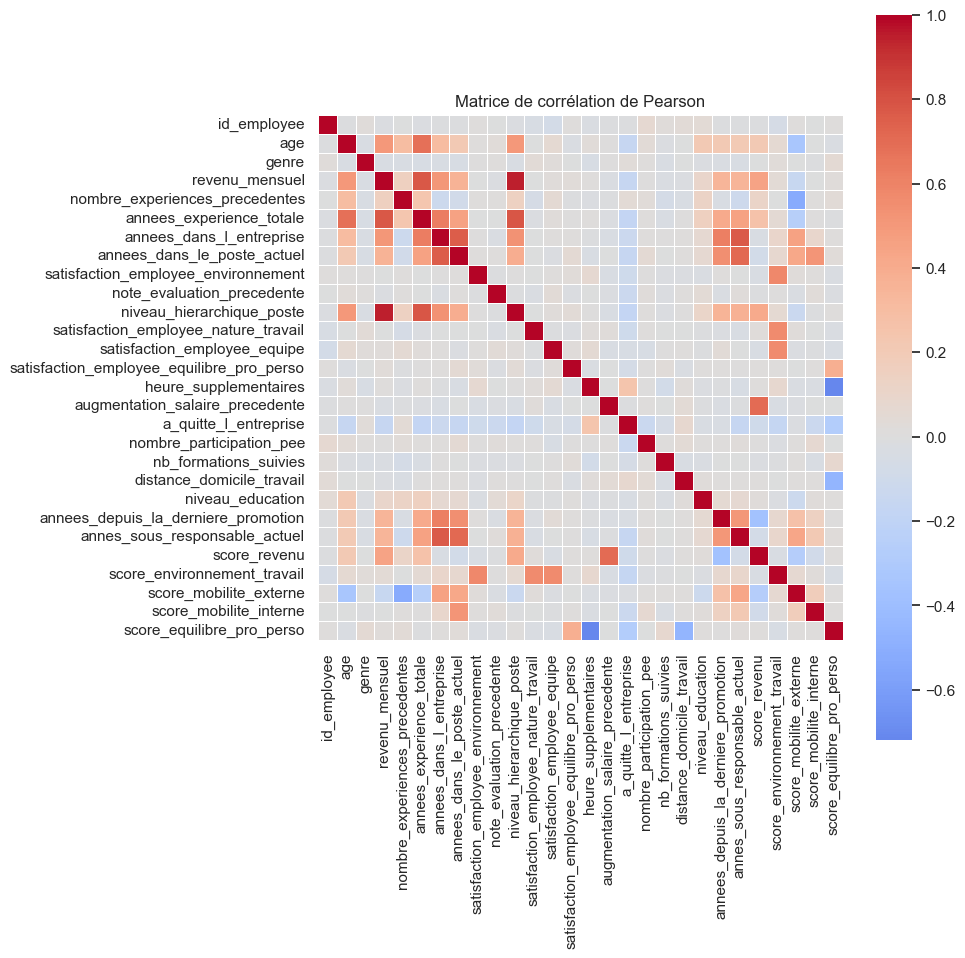

In [58]:
# Sélectionner uniquement les colonnes numériques pour l'analyse de corrélation
numeric_cols = fc.select_dtypes(include=[np.number])
# Calculer la matrice de corrélation entre toutes les variables numériques
corrmat = numeric_cols.corr()
# Créer une figure de taille appropriée pour visualiser toutes les corrélations
f, ax = plt.subplots(figsize=(10, 10))
# Générer la heatmap de corrélation
sns.heatmap(corrmat,
            cmap='coolwarm',  # Palette de couleurs adaptée aux corrélations (bleu=négatif, rouge=positif)
            center=0,  # Centrer la palette de couleurs sur 0
            square=True,  # Cellules carrées pour un meilleur rendu visuel
            linewidths=0.5)  # Ajouter des lignes de séparation entre les cellules

plt.title('Matrice de corrélation de Pearson')
plt.tight_layout()  # Ajuster automatiquement la mise en page
plt.show()


# Création de nouvelles features

In [59]:
# Satisfaction Globale
fc["satisfaction_globale"] = ((fc["satisfaction_employee_environnement"]+fc["satisfaction_employee_nature_travail"]+fc["satisfaction_employee_equipe"]+fc["satisfaction_employee_equilibre_pro_perso"])/16).round(2)


# Méthode d’encoding adaptée pour les features qualitatives

In [60]:
col_onehot = ["poste", "domaine_etude", "statut_marital", "departement"]

# Initialisation du DataFrame transformé
fc_transformed = pd.DataFrame(index=fc.index)

# One-Hot Encoding
ohe = OneHotEncoder(dtype=int, sparse_output=False)
onehot_encoded = ohe.fit_transform(fc[col_onehot])
onehot_cols = ohe.get_feature_names_out(col_onehot)
fc_transformed[onehot_cols] = onehot_encoded

# 4. Colonnes restantes (passthrough)
remaining_cols = [col for col in fc.columns
                  if col not in col_onehot]
if remaining_cols:
    fc_transformed[remaining_cols] = fc[remaining_cols]

# Tri des colonnes par ordre alphabétique
fc = fc_transformed.sort_index(axis=1)

fc["frequence_deplacement"] = fc["frequence_deplacement"].map({"Aucun":0, "Occasionnel":0.5, "Frequent":1})

# Matrice de corrélation de Spearman

- Tracer un pairplot pour mesurer l’intensité des corrélations non-linéaires

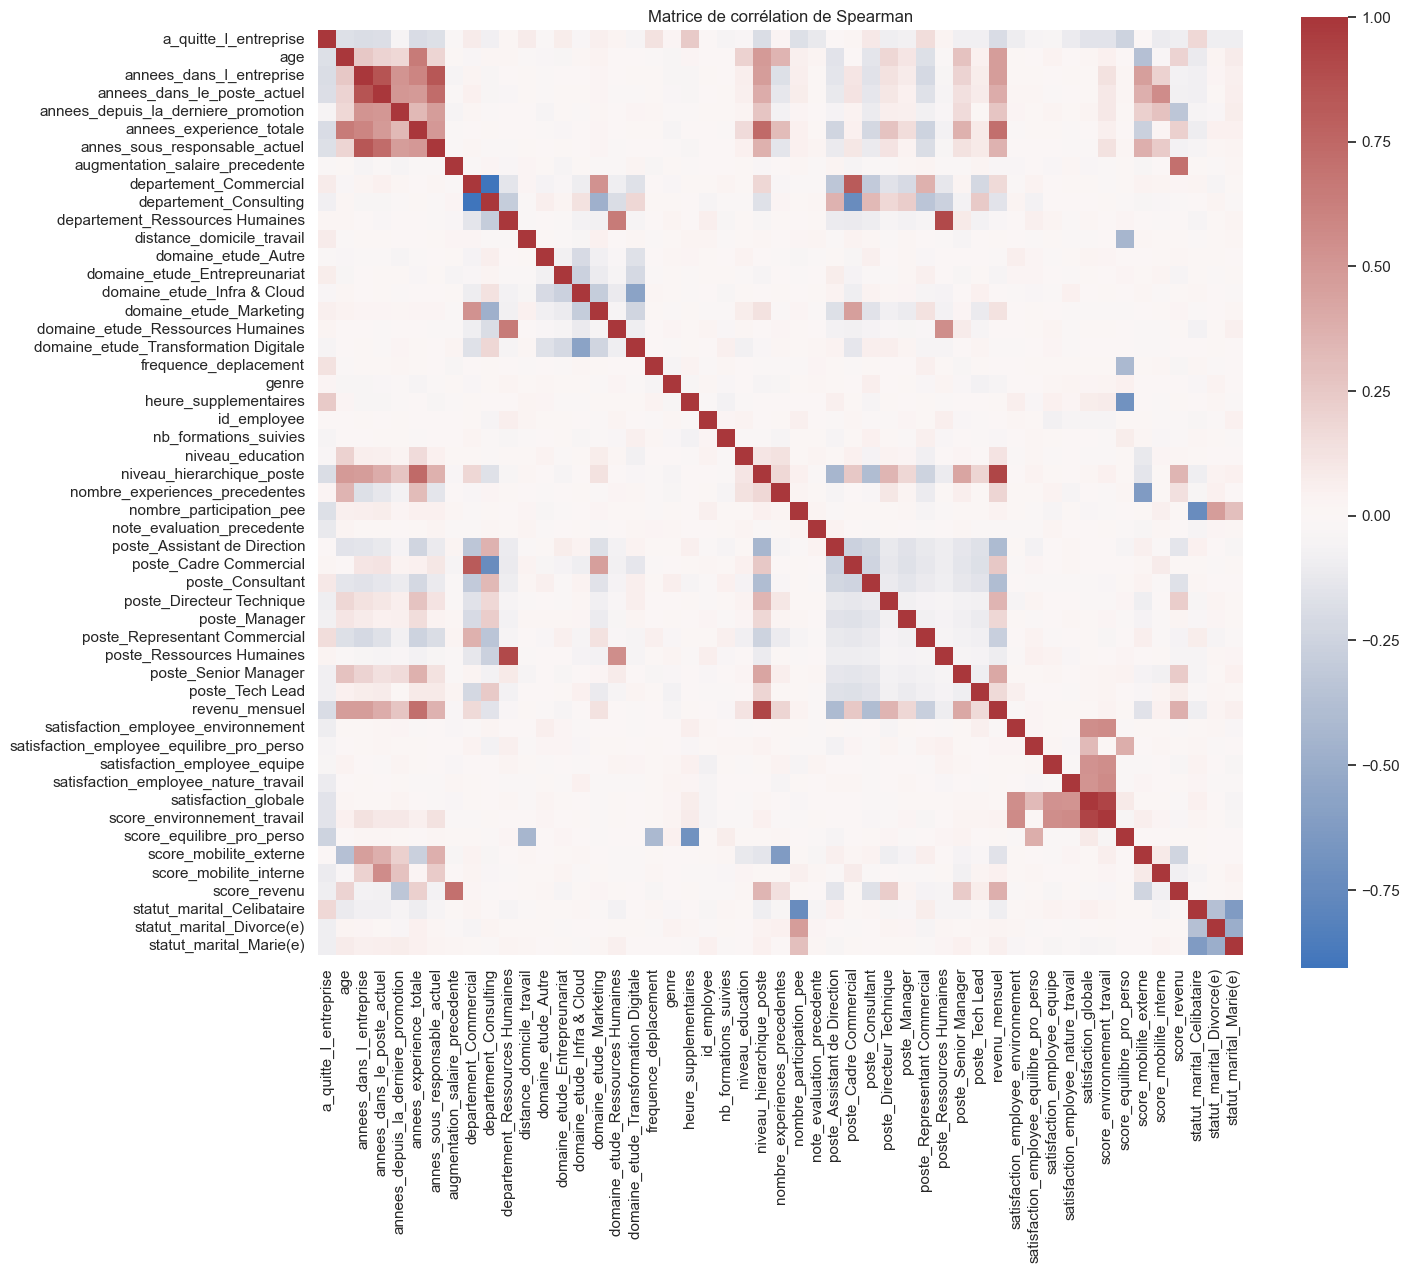

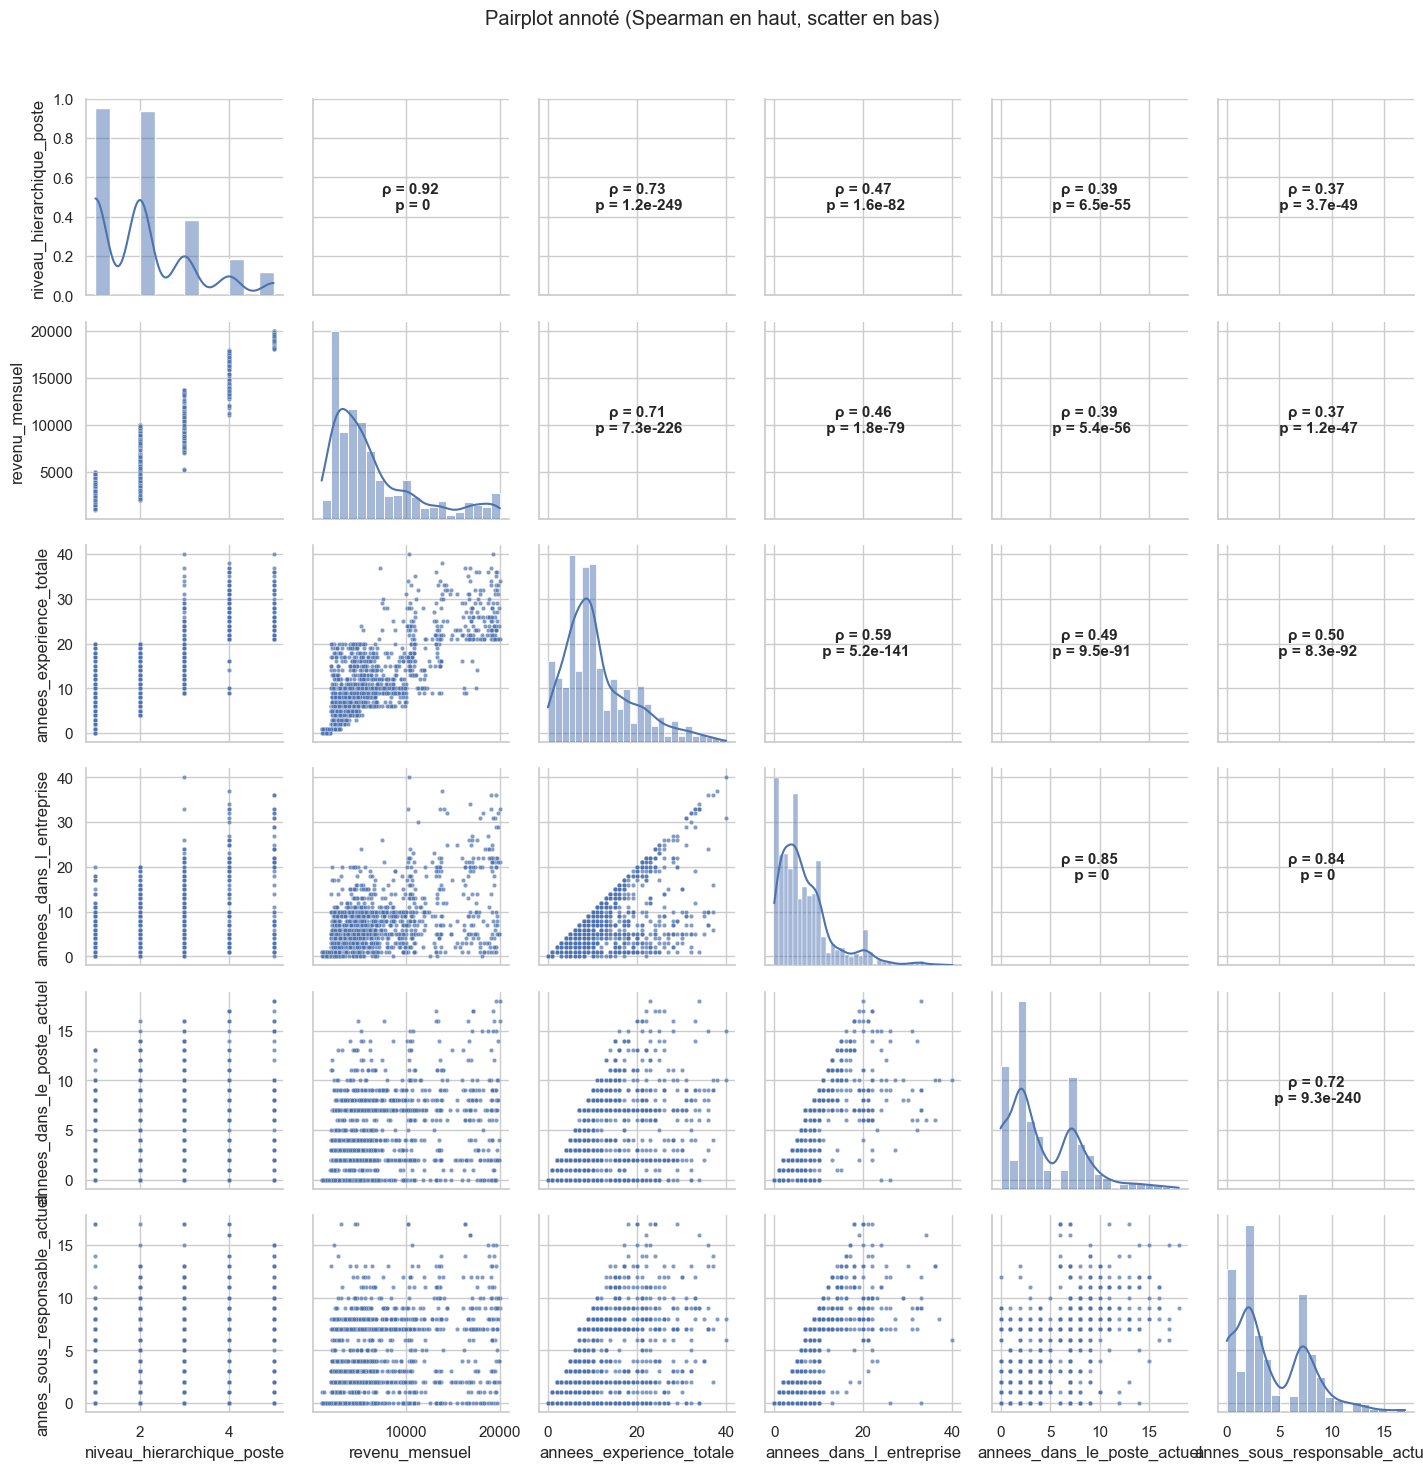

In [61]:
sns.set(style="whitegrid")

# --- 1) Matrice de corrélation de Spearman (valeurs + p-values optionnelles) ---
spearman_corr = fc.corr(method="spearman")  # matrice simple des coefficients
# si on veut p-values :
def spearman_matrix_with_pvals(data):
    cols = data.columns
    n = len(cols)
    corr = pd.DataFrame(np.zeros((n,n)), index=cols, columns=cols)
    pval = pd.DataFrame(np.zeros((n,n)), index=cols, columns=cols)
    for i, a in enumerate(cols):
        for j, b in enumerate(cols):
            if i <= j:
                r, p = spearmanr(data[a], data[b], nan_policy='omit')
                corr.loc[a,b] = corr.loc[b,a] = r
                pval.loc[a,b] = pval.loc[b,a] = p
    return corr, pval

corr, pvals = spearman_matrix_with_pvals(fc)

# Heatmap annotée (Spearman)
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=False, fmt=".2f", cmap="vlag", center=0, square=True,
            cbar_kws={"shrink":0.75})
plt.title("Matrice de corrélation de Spearman")
plt.tight_layout()
plt.show()


# --- 2) PairGrid avec scatter en bas et annotation du coefficient Spearman en haut ---
def annotate_spearman(x, y, **kws):
    r, p = spearmanr(x, y, nan_policy='omit')
    ax = plt.gca()
    text = f"ρ = {r:.2f}\n p = {p:.2g}"
    # placer le texte centré
    ax.annotate(text, xy=(0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center', fontsize=11, weight='bold')

# 1️⃣ Calcul de la corrélation (Spearman)
corr = fc.corr(method='spearman').abs()

# 2️⃣ Sélectionner les k colonnes les plus corrélées avec la cible (ou globalement)
# Ici, on prend les k colonnes les plus corrélées entre elles (excluant la diagonale)
k = 6
# Somme des corrélations pour chaque colonne (minus self-correlation)
col_corr_sum = corr.sum() - 1  # on retire la diagonale
top_cols = col_corr_sum.sort_values(ascending=False).head(k).index.tolist()

g = sns.PairGrid(fc[top_cols], diag_sharey=False, corner=False, height=2.4)

# lower : scatter (ou scatter + lowess si utile)
g.map_lower(sns.scatterplot, s=10, alpha=0.7)

# upper : afficher le coeff de Spearman
g.map_upper(annotate_spearman)

# diag : histogrammes
g.map_diag(sns.histplot, kde=True)

plt.suptitle("Pairplot annoté (Spearman en haut, scatter en bas)", y=1.02)
plt.tight_layout()
plt.show()


# --- Conseils supplémentaires ---
# 1) Si tu veux détecter corrélations non-monotones (ex: U-shape), Spearman peut rater;
#    envisager d'autres mesures (MIC, distance correlation, mutual information).
# 2) Pour mettre en évidence une tendance non-linéaire monotone dans les nuages de points,
#    tu peux remplacer map_lower(sns.scatterplot) par sns.regplot(..., lowess=True) sur chaque paire.
# 3) Pour de grandes dimensions (>10), le pairplot devient illisible : préférer heatmap + méthodes de réduction de dimension (PCA, t-SNE, UMAP).

# Export CSV

In [62]:
fc.to_csv('fc_after_feature_engineering.csv', index=False)